In [1]:
%load_ext lab_black
%cd ..

/mnt/h/hev/motion-keypoint


In [2]:
import argparse
import json
import math
import os
import shutil
import sys
from multiprocessing import cpu_count
from pathlib import Path
from pprint import pformat
from random import randint, random

import imageio
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from easydict import EasyDict
from PIL import Image
from torch import nn, optim
from torch.optim import lr_scheduler
from tqdm import tqdm

import networks
import utils
from datasets import get_det_dataset, TestDetDataset

from importlib import import_module
from itertools import product
from collections import defaultdict
import cv2

## 모델 로딩

In [3]:
main = import_module("main-effdet-train")

In [4]:
with open("config/effdet-d7.yaml", "r") as f:
    C = EasyDict(yaml.load(f, yaml.FullLoader))

utils.seed_everything(C.seed)

In [5]:
C.dataset.input_width, C.dataset.input_height = 1536, 1024

In [6]:
C

{'seed': 20210309,
 'result_dir': 'results/effdet-train',
 'comment': None,
 'det_model': {'name': 'efficientdet-d7'},
 'dataset': {'dir': 'data/ori',
  'batch_size': 2,
  'num_cpus': 1,
  'padding': 20,
  'group_kfold': False,
  'crop': [192, 28, 1728, 1052],
  'input_width': 1536,
  'input_height': 1024},
 'train': {'SAM': False,
  'earlystop_patience': 10,
  'start_epoch': 1,
  'final_epoch': 200,
  'batch_augmentation': True,
  'folds': [1],
  'checkpoints': [None],
  'lr': 0.0001,
  'scheduler': {'type': 'ReduceLROnPlateau',
   'params': {'factor': 0.5, 'patience': 3, 'verbose': True}}}}

In [7]:
# trainer = main.DetTrainer(C, 1, "results/effdet-train/efficientdet-d0-1536x1024-pad20-ba_1_1.pth")
trainer = main.DetTrainer(C, 1, None)

Load pretrained /home/s0/.cache/torch/hub/checkpoints/efficientdet-d7.pth


In [8]:
model = trainer.det_model

In [9]:
model.eval()
torch.set_grad_enabled(False)

## 데이터셋 로딩

In [10]:
# sizes = [(384, 256), (768, 512), (1536, 1024)]
sizes = [(768, 512), (1536, 1024)]
# sizes = [(768, 512)]
# rotations = [0, 1, 2, 3]
rotations = [0, 1, 3]
# rotations = [0]
vflips = [False, True]
# vflips = [False]
hflips = [False, True]
# hflips = [False]
# gammas = [0.7, 0.8, 0.9, 1.0, 1.1]
gammas = [0.8, 1.0]
# gammas = [1.0]

In [11]:
test_files = sorted(list(Path("data/ori/test_imgs/").glob("*.jpg")))
len(test_files)

1600

In [12]:
ds = TestDetDataset(C, test_files)

In [13]:
ds[0]

('data/ori/test_imgs/649-2-4-32-Z148_A-0000001.jpg',
 tensor([[[-1.3302, -1.3302, -1.3302,  ...,  1.8379,  1.8379,  1.8379],
          [-1.3302, -1.3302, -1.3302,  ...,  1.8379,  1.8379,  1.8379],
          [-1.3302, -1.3302, -1.3302,  ...,  1.8379,  1.8379,  1.8379],
          ...,
          [-1.2445, -1.2445, -1.2445,  ..., -1.0390, -1.0390, -1.0390],
          [-1.2445, -1.2445, -1.2445,  ..., -1.0390, -1.0390, -1.0390],
          [-1.2274, -1.2274, -1.2274,  ..., -1.0390, -1.0390, -1.0390]],
 
         [[-1.3354, -1.3354, -1.3354,  ...,  2.0784,  2.0784,  2.0784],
          [-1.3354, -1.3354, -1.3354,  ...,  2.0784,  2.0784,  2.0784],
          [-1.3354, -1.3354, -1.3354,  ...,  2.0784,  2.0784,  2.0784],
          ...,
          [-1.1078, -1.1078, -1.1078,  ..., -0.8978, -0.8978, -0.8978],
          [-1.1078, -1.1078, -1.1078,  ..., -0.8978, -0.8978, -0.8978],
          [-1.0903, -1.0903, -1.0903,  ..., -0.8978, -0.8978, -0.8978]],
 
         [[-1.1073, -1.1073, -1.1073,  ...,  2.

In [14]:
file, img = ds[0]

In [15]:
img_np = utils.denormalize(img).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()

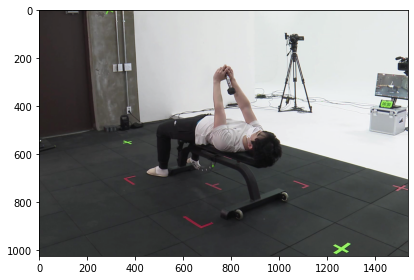

In [16]:
utils.imshows(img_np)

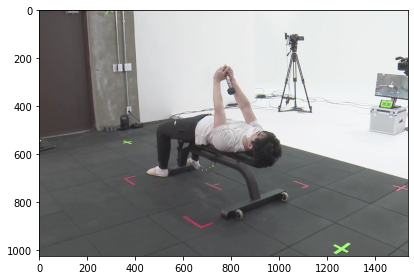

In [17]:
utils.imshows((utils.denormalize(img) ** 0.7).permute(1, 2, 0).mul(255).type(torch.uint8).numpy())

In [14]:
L = len(ds)

In [47]:
imgs = []
with tqdm(total=L, ncols=100, file=sys.stdout) as t:
    for i in range(L):
        file, img = ds[i]
        for size, rotation, vflip, hflip, gamma in product(sizes, rotations, vflips, hflips, gammas):
            img_ = img.cuda().unsqueeze(0)
            if gamma != 1.0:
                img_ = utils.normalize(utils.denormalize(img_) ** gamma)
            if C.dataset.input_height != size[1] and C.dataset.input_width != size[0]:
                img_ = F.interpolate(img_, size[::-1])
            if rotation > 0:
                img_ = torch.rot90(img_, k=rotation, dims=(2, 3))
            if vflip:
                img_ = torch.flip(img_, dims=(2,))
            if hflip:
                img_ = torch.flip(img_, dims=(3,))

            img_np = imgs.append(utils.denormalize(img_).mul(255).squeeze(0).permute(1, 2, 0).cpu().type(torch.uint8).numpy())

        t.update()
        break

  0%|                                                              | 1/1600 [00:01<41:38,  1.56s/it]


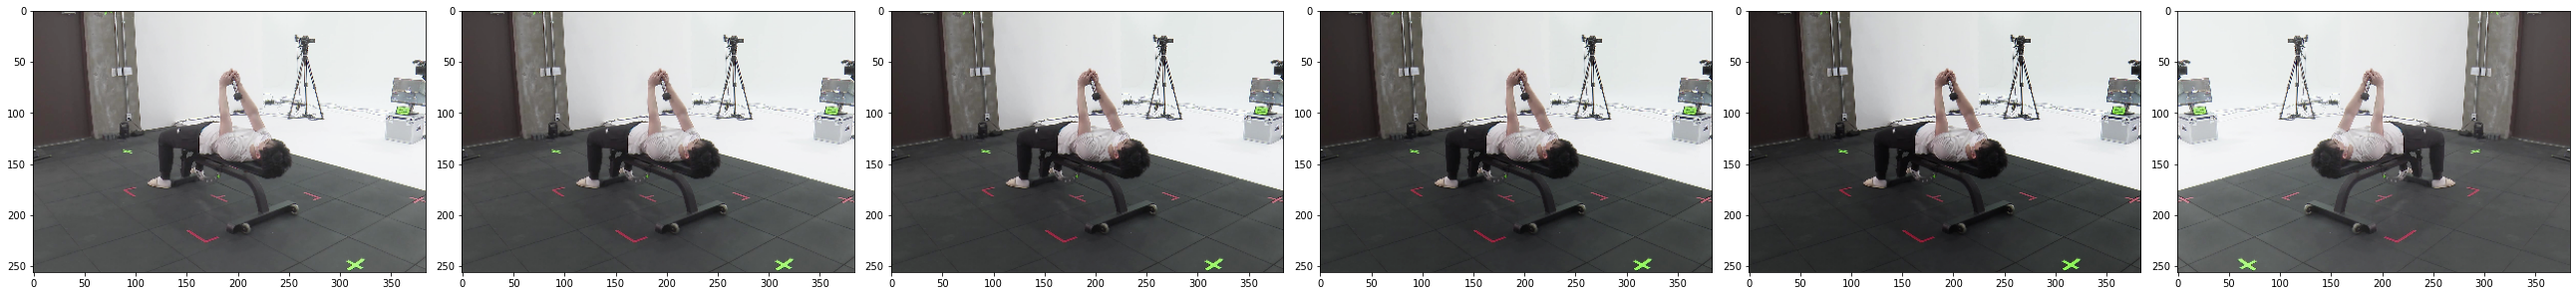

In [49]:
utils.imshows(*imgs[0:6])

In [61]:
len(imgs)

240

In [63]:
size_dict = defaultdict(list)
for img in imgs:
    size_dict[img.shape].append(img)

In [65]:
for key, items in size_dict.items():
    print(key, len(items))

(256, 384, 3) 40
(384, 256, 3) 40
(512, 768, 3) 40
(768, 512, 3) 40
(1024, 1536, 3) 40
(1536, 1024, 3) 40


## Multiscale Test

In [17]:
with tqdm(total=L, ncols=100, file=sys.stdout) as t:
    for i in range(L):
        file, img = ds[i]
        rois, scores = [], []
        for size, rotation, vflip, hflip, gamma in product(sizes, rotations, vflips, hflips, gammas):
            img_ = img.cuda().unsqueeze(0)
            if gamma != 1.0:
                img_ = utils.normalize(utils.denormalize(img_) ** gamma)
            if C.dataset.input_height != size[1] and C.dataset.input_width != size[0]:
                img_ = F.interpolate(img_, size[::-1])
            if rotation > 0:
                img_ = torch.rot90(img_, k=rotation, dims=(2, 3))
            if vflip:
                img_ = torch.flip(img_, dims=(2,))
            if hflip:
                img_ = torch.flip(img_, dims=(3,))

            # img_np = imgs.append(utils.denormalize(img_).mul(255).squeeze(0).permute(1, 2, 0).cpu().type(torch.uint8).numpy())
            pannot = model(img_)[0]

            roi, score = None, None
            for roi_, class_id_, score_ in zip(pannot["rois"], pannot["class_ids"], pannot["scores"]):
                if class_id_ != 0:
                    continue

                if score_ < 0.6:
                    continue

                if roi is None or (roi[2] - roi[0]) * (roi[3] - roi[1]) < (roi_[2] - roi_[0]) * (roi_[3] - roi_[1]):
                    roi = roi_
                    score = score_

            if roi is not None and score is not None:
                roi, score = pannot["rois"][0], pannot["scores"][0]
                h, w = img_.shape[2:]

                if hflip:
                    a, b, c, d = roi.copy()
                    roi = np.array([w - c, b, w - a, d], dtype=np.float32)
                if vflip:
                    a, b, c, d = roi.copy()
                    roi = np.array([a, h - d, c, h - b], dtype=np.float32)
                if rotation > 0:
                    a, b, c, d = roi.copy()
                    if rotation == 1:
                        roi = np.array([h - d, a, h - b, c], dtype=np.float32)
                        h, w = w, h
                    elif rotation == 2:
                        roi = np.array([w - c, h - d, w - a, h - b], dtype=np.float32)
                    elif rotation == 3:
                        roi = np.array([b, w - c, d, w - a], dtype=np.float32)
                        h, w = w, h
                if C.dataset.input_height != size[1] and C.dataset.input_width != size[0]:
                    roi[0::2] = roi[0::2] * C.dataset.input_width / w
                    roi[1::2] = roi[1::2] * C.dataset.input_height / h

                rois.append(roi)
                scores.append(score)

        t.update()
        break

  0%|                                                            | 1/1600 [00:16<7:17:44, 16.43s/it]


In [18]:
rois = np.stack(rois)

In [19]:
rois.shape

(60, 4)

In [20]:
roi = np.median(rois, 0)

In [21]:
roi

array([ 447.33295,  226.88168, 1013.6953 ,  698.145  ], dtype=float32)

In [22]:
C.dataset.crop

[192, 28, 1728, 1052]

In [23]:
roi[0::2] += C.dataset.crop[0]
roi[1::2] += C.dataset.crop[1]

In [24]:
roi

array([ 639.33295,  254.88168, 1205.6953 ,  726.145  ], dtype=float32)

In [25]:
img_ori = imageio.imread(file)

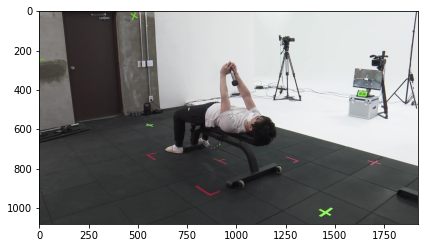

In [26]:
utils.imshows(img_ori)

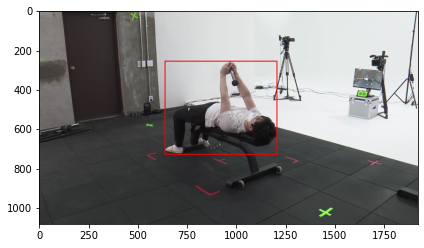

In [27]:
utils.imshows(cv2.rectangle(img_ori, (638, 254), (1205, 726), (255, 0, 0), 3))

## 모든 test 파일들 잘라내기

In [15]:
outdir = Path("results/effdet-train/example/efficientdet-d7-official_2")
outdir.mkdir(parents=True, exist_ok=True)

In [20]:
info = []
with tqdm(total=100, ncols=100, file=sys.stdout) as t:
    for i in range(700, 800):
        file, img = ds[i]
        file = Path(file)
        rois, scores = [], []
        for size, rotation, vflip, hflip, gamma in product(sizes, rotations, vflips, hflips, gammas):
            img_ = img.cuda().unsqueeze(0)
            if gamma != 1.0:
                img_ = utils.normalize(utils.denormalize(img_) ** gamma)
            if C.dataset.input_height != size[1] and C.dataset.input_width != size[0]:
                img_ = F.interpolate(img_, size[::-1])
            if rotation > 0:
                img_ = torch.rot90(img_, k=rotation, dims=(2, 3))
            if vflip:
                img_ = torch.flip(img_, dims=(2,))
            if hflip:
                img_ = torch.flip(img_, dims=(3,))

            # img_np = imgs.append(utils.denormalize(img_).mul(255).squeeze(0).permute(1, 2, 0).cpu().type(torch.uint8).numpy())
            pannot = model(img_)[0]

            roi, score = None, None
            for roi_, class_id_, score_ in zip(pannot["rois"], pannot["class_ids"], pannot["scores"]):
                if class_id_ != 0:
                    continue

                if score_ < 0.4:
                    continue

                if roi is None or (roi[2] - roi[0]) * (roi[3] - roi[1]) < (roi_[2] - roi_[0]) * (roi_[3] - roi_[1]):
                    roi = roi_
                    score = score_

            if roi is not None and score is not None:
                roi, score = pannot["rois"][0], pannot["scores"][0]
                h, w = img_.shape[2:]

                if hflip:
                    a, b, c, d = roi.copy()
                    roi = np.array([w - c, b, w - a, d], dtype=np.float32)
                if vflip:
                    a, b, c, d = roi.copy()
                    roi = np.array([a, h - d, c, h - b], dtype=np.float32)
                if rotation > 0:
                    a, b, c, d = roi.copy()
                    if rotation == 1:
                        roi = np.array([h - d, a, h - b, c], dtype=np.float32)
                        h, w = w, h
                    elif rotation == 2:
                        roi = np.array([w - c, h - d, w - a, h - b], dtype=np.float32)
                    elif rotation == 3:
                        roi = np.array([b, w - c, d, w - a], dtype=np.float32)
                        h, w = w, h
                if C.dataset.input_height != size[1] and C.dataset.input_width != size[0]:
                    roi[0::2] = roi[0::2] * C.dataset.input_width / w
                    roi[1::2] = roi[1::2] * C.dataset.input_height / h

                rois.append(roi)
                scores.append(score)

        rois = np.stack(rois)
        roi = np.median(rois, 0)
        roi[0::2] += C.dataset.crop[0]
        roi[1::2] += C.dataset.crop[1]
        offset = C.dataset.crop[:2]

        info.append({"roi": roi.tolist(), "offset": offset})

        # 이미지 파일로 저장
        img_ori = imageio.imread(file)
        cv2.rectangle(img_ori, (int(roi[0]), int(roi[1])), (int(roi[2]), int(roi[3])), (255, 0, 0), 3)
        imageio.imwrite(outdir / f"{i:04d}-{file.name}", img_ori)

        t.update()

100%|█████████████████████████████████████████████████████████████| 100/100 [09:07<00:00,  5.48s/it]


In [22]:
with open(outdir / "info_5.json", "w") as f:
    json.dump(info, f)

---

## info 파일들 합치기

In [ ]:
# info_files = [
#     outdir / 'info_0.json',
#     outdir / 'info_1.json',
#     outdir / 'info_2.json',
#     outdir / 'info_3.json',
#     outdir / 'info_5.json',
#     outdir / 'info_6.json',
#     outdir / 'info_7.json',
# ]

In [23]:
def read_json(path):
    with open(path, "r") as f:
        return json.load(f)

In [27]:
info0 = read_json(outdir / "info_0.json")
info1 = read_json(outdir / "info_1.json")
info5 = read_json(outdir / "info_5.json")
info6 = read_json(outdir / "info_6.json")
info7 = read_json(outdir / "info_7.json")
info3 = read_json(outdir / "info_3.json")
info4 = read_json(outdir / "info_4.json")

In [28]:
info = info0 + info1 + info5 + info6 + info7 + info3 + info4

In [29]:
len(info)

1600

In [30]:
with open(outdir / "info.json", "w") as f:
    json.dump(info, f)